<b> Joshua Chen <br>
Professor Jack Jewsom <br>
Computation Machine Learning <br>
</b>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.impute import SimpleImputer
from helper_functions import GridSearch_table_plot
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import random

## Setting Up The Data

#### Import the Data

Setting the seed, importing the data. icd9deadly and deadly are two data sets I made that include the unique words in icd9 and diagnosis respectively, their total counts, and the dead counts. I split the replaced ICD9 codes with the short diagnosis and then separated the words in columns by spaces. From this, I was able to get the means and counts for each disease. This was for my own exploration. I tried to use this but it wasn't particularly helpful, although it was fun to explore.

In [2]:
random.seed(1234)
trainset = pd.read_csv("data/mimic_train.csv")
testset = pd.read_csv("data/mimic_test_death.csv")
metadata = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
icd9deadly = pd.read_csv('icd9deadly.csv', index_col = 0)
deadly =pd.read_csv('deadly.csv', index_col= 0)

Features I chose to work with and loading the datasets.

In [3]:
features = ['subject_id','hadm_id','HeartRate_Min','HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 
        'SysBP_Max','SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
        'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
        'SpO2_Min','SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
        'Glucose_Mean','RespRate_Min', 'RespRate_Max', 'RespRate_Mean','TempC_Min', 'TempC_Max', 'TempC_Mean', 
        'Diff','DIAGNOSIS', 'DOB','ADMITTIME','ADMISSION_TYPE', 'ETHNICITY', 'GENDER', 'INSURANCE', 'FIRST_CAREUNIT']

X_raw = trainset[features]
y_tab = trainset['HOSPITAL_EXPIRE_FLAG']
test = testset[features]
X_shape = X_raw.copy()
X_split = X_raw.copy()

I structured my notebook so I can choose whether or not to do a train, test split. I was submitting on Kaggle after every time I did something, and wanted a more concrete way to test any changes other than just guessing and checking with Kaggle. I ensured that there is no data leakage in this notebook. For example, if I choose to do a train test split, the means for ICD9 data and diagnosis are made only with the training data.

In [4]:
X_shape, X_test, y, y_test = train_test_split(X_shape, y_tab, test_size=0.1, random_state=31415)
y1 = y.copy()


<b> Comment these out if you want to do Train Test Split </b>

Simple way to alternate between train, test split and training on the whole dataseet.

In [5]:
X_shape = X_raw.copy()
y = y_tab.copy()
y1 = y_tab.copy()

Just making extra copies for when I want to try different things out.

In [6]:
X_shape1 = X_shape.copy()
X_test1 = X_test.copy()
test1 = test.copy()

## PCA on Vitals

Because kNN, after scaling, weights each dimension equally, I was concerned that there was an unbalanced number of columns dedicated purely to vitals. For example, there are 9 columns dedicated to blood pressure and, originally, only one dedicated to diagnosis. Therefore, I decided to try PCA to reduce dimensionality. For kNN, my best predictions were using PCA. However, for SVM, my best results were if I neglected PCA. I assume this is because, as kNN is worse at handling noise and extra dimensions, reducing dimensionality is worth some of the information lost. SVM handles the extra dimensions better so I assume it's not worth the information lost.

In [7]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

selected_columns = X_shape.iloc[:, range(2,26)]

pca_scaler = StandardScaler()

pca_scaler.fit(selected_columns)
X_standardized = pca_scaler.transform(selected_columns)
imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
X_standardized = pd.DataFrame(imp_mean.fit_transform(X_standardized))

n_components = 24
pca = PCA(n_components=n_components)
pca.fit(X_standardized)
subset_transformed = pca.transform(X_standardized)

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.20921801, 0.14788374, 0.10620169, 0.08558184, 0.07691429,
       0.07068737, 0.05937822, 0.03638062, 0.03273919, 0.03100623,
       0.02543027, 0.02284497, 0.01950411, 0.01548056, 0.01333253,
       0.01172303, 0.00902808, 0.00783833, 0.00657567, 0.00328627,
       0.0027944 , 0.00251446, 0.00245123, 0.00120487])

I graphed the variances of the PCA comonponents to decide which to keep. Here, it was a bit difficut to idenity the elbow but testing confirmed that 8 components was prefered. This makes sense as there are 8 vitals, each with its own mean, max, and minimum.

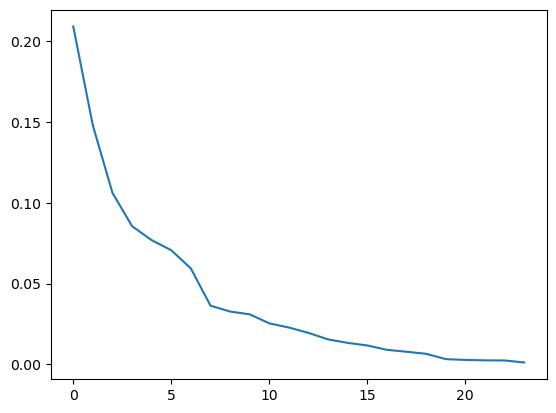

In [8]:
plt.plot(explained_variance)
plt.show()

Simple way to choose how many components that you would like to keep. Just add or subtract columns via names below.

In [9]:
pca_cols = ['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8']

Replacing vitals columns in training data with PCA columns. I also tried transforming PCA exponentially or logarithmically just to see if it was beneficial but it proved meainingless.

In [10]:
Xs = pd.DataFrame(subset_transformed)

Xs = Xs.iloc[:,:len(pca_cols)]
Xs.columns = pca_cols
#Xs = np.log(Xs)
#Xs = np.exp(Xs)
X_id = X_shape.iloc[:,:2]
X_back = X_shape.iloc[:,26:]
X_id = X_id.reset_index(drop=True)
Xs = Xs.reset_index(drop=True)
X_back = X_back.reset_index(drop=True)
X_shape = pd.concat([X_id, Xs,X_back], axis=1)

Doing the same exact thing for the testing set, making sure to fit-transform on the training set.

In [11]:
Xtest_selected_columns = X_test.iloc[:, range(2,26)]

Xtest_standardized = pca_scaler.transform(Xtest_selected_columns)

imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
test_standardized = pd.DataFrame(imp_mean.fit_transform(Xtest_standardized))

Xtsubset_pca = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_
explained_variance


array([0.20921801, 0.14788374, 0.10620169, 0.08558184, 0.07691429,
       0.07068737, 0.05937822, 0.03638062, 0.03273919, 0.03100623,
       0.02543027, 0.02284497, 0.01950411, 0.01548056, 0.01333253,
       0.01172303, 0.00902808, 0.00783833, 0.00657567, 0.00328627,
       0.0027944 , 0.00251446, 0.00245123, 0.00120487])

In [12]:
Xt = pd.DataFrame(Xtsubset_pca)
Xt = Xt.iloc[:,:len(pca_cols)]
Xt.columns = pca_cols
#Xt = np.log(Xt)
#Xt = np.exp(Xt)
Xt_id = X_test.iloc[:,:2]
Xt_back = X_test.iloc[:,26:]
Xt_id = Xt_id.reset_index(drop=True)
Xt = Xt.reset_index(drop=True)
Xt_back = Xt_back.reset_index(drop=True)
X_test = pd.concat([Xt_id, Xt, Xt_back], axis=1)


Doing the same thing again for the final Kaggle testing set.

In [13]:
test_selected_columns = test.iloc[:, range(2,26)]

test_standardized = pca_scaler.transform(test_selected_columns)

imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
test_standardized = pd.DataFrame(imp_mean.fit_transform(test_standardized))

testsubset_pca = pca.transform(test_standardized)

explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.20921801, 0.14788374, 0.10620169, 0.08558184, 0.07691429,
       0.07068737, 0.05937822, 0.03638062, 0.03273919, 0.03100623,
       0.02543027, 0.02284497, 0.01950411, 0.01548056, 0.01333253,
       0.01172303, 0.00902808, 0.00783833, 0.00657567, 0.00328627,
       0.0027944 , 0.00251446, 0.00245123, 0.00120487])

Plotting the explained variance of the tesitng set.

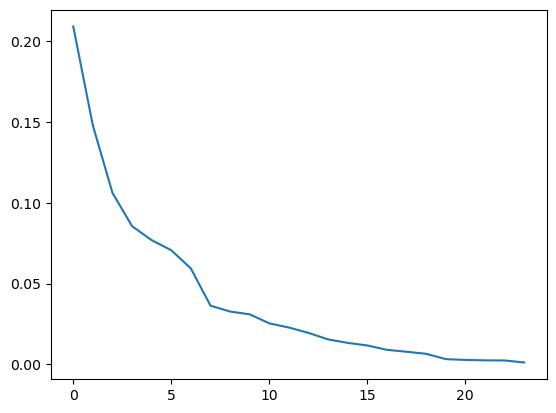

In [14]:
plt.plot(explained_variance)
plt.show()

In [15]:
hi = pd.DataFrame(testsubset_pca)
hi = hi.iloc[:,:len(pca_cols)]
hi.columns = pca_cols
#hi = np.log(hi)
#hi = np.exp(Xt)
test_id = test.iloc[:,:2]
test_back = test.iloc[:,26:]
test = test_id.reset_index(drop=True)
hi = hi.reset_index(drop=True)
test_back = test_back.reset_index(drop=True)
test = pd.concat([test_id, hi,test_back], axis=1)

<b>Comment out if I don't want to use PCA.</b>

In [16]:
X_shape1 = X_shape.copy()
X_test1 = X_test.copy()
test1 = test.copy()

## Disease Dummies

This was my original idea for the diagnosis column. Orginially, I explored the dataset I created of unique elements within the Diagnosis column. I noticed the some things, like Penumonia, would appear frequently but sometimes within other contexts. Therefore, I selected some deadly diseases that had significant number of people affected and created a dummy column for them. Originally this was around 12 different diseases. However, this proved an ineffective way to deal with diagnosis as so much information is lost.

The dummmies chose below ended up being some of the top killers as listed by CDC 2012 data. This never ended up being particularly effective in my model and was left largely unused.

In [17]:
words = ("HEART","CANCER","STROKE","PNEUMO","DIABETES","KIDNEY")

def disease_dum(df_, words):
    df = df_.copy()
    for word in words:
        df[word] = df['DIAGNOSIS'].str.contains(word).astype(int)
    return df

#Want to see if the string contains the word.

## Diagnosis

Created a dictionary to mean encode diagnoses. I don't like how some things that are similar are not grouped together, which originally was the reason I separated the strings originally. However, this proved much more effective than what I was doing. Although, as always with mean ecoding, I am overfitting and unable to accomadate new diseases.

In [18]:
count = X_shape['DIAGNOSIS'].value_counts()

y1 = y.reindex(X_shape.index)

ddead = X_shape[y1 == 1]['DIAGNOSIS'].value_counts()

ratio = ddead/count
ratio.fillna(0, inplace= True)
merged_diag = ratio.to_dict()

## Metadata and ICD9

For ICD9, I also mean encoded death ratios. I collapsed the metadata by the sequence numbers so that I could add columns for each subsequent person.

In [19]:
pivoted_df = metadata.pivot(index=['SUBJECT_ID', 'HADM_ID'], columns = ['SEQ_NUM'], values='ICD9_CODE')
pivoted_df.reset_index(inplace=True)
pivoted_df = pivoted_df.reset_index(drop=True)

Here, I am merging so that I can create a dictionary with all the mean values of any ICD9 in the data. Again, my notebook is set up to prevent data leakage for train test splits. Only ICD9 in the training set will be used to create the dictionary and calculate death percentages.

In [20]:
X_shape.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'}, inplace=True)
X_dict = X_shape.merge(pivoted_df, on=['SUBJECT_ID', 'HADM_ID'], how='left')

In [21]:
just_icd9 = X_dict.iloc[:,-40:]
all_icd9_series = just_icd9.stack()
icd9_counts = all_icd9_series.value_counts()

dead_icd9 = just_icd9[y1 == 1].stack()
dead = dead_icd9.value_counts()

ratio = dead/icd9_counts
ratio.fillna(0, inplace= True)
merged = ratio.to_dict()

I noticed that the ICD9s were not ordered by greatest percentage. I am not sure if there was a medical reason as to why they are ordered. I believe the first ICD9 is the primary diagnosis. However, I thought it made sense to group someones most deadly diangoses in the same column to compare. This was not something I am completely sold on due to my lack of medical knowledge but it did marginally improve predictions.

In [22]:
icd9_mapped= pivoted_df.iloc[:,3:].applymap(merged.get)
icd9_mapped = icd9_mapped.apply(lambda row: sorted(row, reverse=True), axis=1, result_type='broadcast')
pivoted_df.iloc[:,3:] = icd9_mapped

/var/folders/7g/swv044q57cq378zvy5rc1fj80000gn/T/ipykernel_54518/2802383290.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pivoted_df.iloc[:,3:] = icd9_mapped


I included some exploratory columns to ICD9, as I assumed that the diagnoses probably had the most predictive power. I included a number of things that I thought might be helpful and saw which was were most helpful with predictions. However, in my last step, I did rearrange ICD9 diagnoses from greatest to least so Max would be redundant to the first column of ICD9 diagnoses. However, it did benefit my out of sample score. I assume this is because I am artifically weighting the most deadly disease greater in kNN. I do try to weight features later.

In [23]:
max_values = icd9_mapped.max(axis=1)
mean_values = icd9_mapped.mean(axis=1)
std_deviation_values = icd9_mapped.std(axis=1)
count_non_null_values = icd9_mapped.count(axis=1)
variance = icd9_mapped.var(axis=1)


summary_df = pd.DataFrame({
    'Max': max_values,
    'Mean': mean_values,
    'StdDev': std_deviation_values,
    'Var': variance,
    'Count': count_non_null_values
})

In [24]:
pivoted_df = pd.concat([pivoted_df, summary_df], axis=1)

In [25]:
pivoted_df

,SUBJECT_ID,HADM_ID,NaN,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,35.0,36.0,37.0,38.0,39.0,Max,Mean,StdDev,Var,Count
0,2,163353,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1
1,3,145834,NaN,0.534290,0.346667,0.342240,0.183445,0.154391,0.140284,0.132517,...,NaN,NaN,NaN,NaN,NaN,0.534290,0.231113,0.144532,0.020889,9
2,4,185777,NaN,0.327869,0.246617,0.222222,0.176471,0.147920,0.094675,0.094118,...,NaN,NaN,NaN,NaN,NaN,0.327869,0.164449,0.086359,0.007458,9
3,5,178980,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,1
4,6,107064,NaN,0.207607,0.200000,0.151579,0.133758,0.114068,0.113931,0.097419,...,NaN,NaN,NaN,NaN,NaN,0.207607,0.137626,0.045909,0.002108,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,99985,176670,NaN,0.362482,0.358608,0.342240,0.298851,0.259259,0.236842,0.158537,...,NaN,NaN,NaN,NaN,NaN,0.362482,0.195111,0.118603,0.014067,13
58972,99991,151118,NaN,0.358608,0.342240,0.318947,0.308036,0.195122,0.183445,0.156863,...,NaN,NaN,NaN,NaN,NaN,0.358608,0.171242,0.103035,0.010616,16
58973,99992,197084,NaN,0.222222,0.215190,0.183445,0.156250,0.105505,0.096017,0.087328,...,NaN,NaN,NaN,NaN,NaN,0.222222,0.109717,0.070569,0.004980,12
58974,99995,137810,NaN,0.151273,0.146006,0.138225,0.132517,0.125996,0.120446,0.113931,...,NaN,NaN,NaN,NaN,NaN,0.151273,0.105666,0.027463,0.000754,17


select_cols chooses which columns to include in the final model. This is an easy way to add and remove things to try.

In [26]:
select_cols = ['Max', 'Mean','StdDev', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0]#,24.0]
pulled_cols = ['SUBJECT_ID', 'HADM_ID'] + select_cols
X_shape = X_shape.merge(pivoted_df[pulled_cols], on=['SUBJECT_ID', 'HADM_ID'], how='left')

## Age

I wrote a function to convert the DOB function into Age (I subtract the DOB from the ADMITTIME. No need for the Diff column as the both the two columns should be off by the same amount. Drop anamoulous individuals with ages recorded over 150) and then I used pd.get_dummies on ADMISSION_TYPE.

In [27]:
def find_age(df_):
    bins = [0, 4, 14, 24, 34, 44, 54, 64, 74, 84, float('inf')]
    labels = ['1–4', '5–14', '15–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75–84', '85 and over']
    df = df_.copy()
    df['DOB'] = pd.to_datetime(df['DOB'])
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
    df['DOB'] = df['DOB'].dt.date
    df['ADMITTIME'] = (df['ADMITTIME']).dt.date
    df['AGE'] = (df['ADMITTIME'] - df['DOB'])
    df['AGE'] = df['AGE'].apply(lambda x: x.days)/365.25
    df['AGE'] = df['AGE']
    df.drop(columns = ["DOB"], inplace = True)
    df.loc[df['AGE'] > 110] = np.nan  
    df['AGE_GROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)    
    df.drop(columns = ["AGE"], inplace = True)
    return df
X_shape = find_age(X_shape)


Originally, because the hospital is in the U.S., I used CDC data from 2012 (the last year that data from this training set was collected) to bin age. I used the per 100,000 death number as the number each bin got mapped to. I ended up mean encoding it as it was substantially better. I tried CDC 2012 data for a number for different demographic identifiers. However, something I thought about later was that the death rates of the entire population is not necessarily reflective of emergency rooms.

In [28]:
death_rates = X_shape[y1== 1]['AGE_GROUP'].value_counts()/X_shape['AGE_GROUP'].value_counts()
age_to_death_rate = death_rates.to_dict()

## Admission Type

I label encoded this. I had intially dropped Urgent, as there was not that many people classified as Urgent. Then I combined Urgent with Emergency and used dummies. However, after seeing that there was clearly a hierarchy, I label encoded them as such.

In [29]:
label_mapping = {'ELECTIVE': 0, 'URGENT': 1, 'EMERGENCY': 2}
label_encoder = LabelEncoder()
label_encoder.fit(list(label_mapping.keys()))


LabelEncoder()

## Ethnicity

Convert ethnicities into either White, Black, Hispanic, Asian, or Other. Similary to age, I started by using CDC data and then tried mean-encoding. However, because there are only 5 classifications of race, I ended up using dummy variables.

In [30]:
keywords = {
    'WHITE': ['WHITE'],
    'BLACK': ['BLACK'],
    'HISPANIC': ['HISPANIC'],
    'ASIAN': ['ASIAN']
}

def classify_ethnicity(text):
   if isinstance(text, str):
        for category, category_keywords in keywords.items():
            if any(keyword in text for keyword in category_keywords):
                return category
        return 'Other' 

def map_demographic(df):
    df['ETHNICITY'] = df['ETHNICITY'].apply(classify_ethnicity)
    df['demographic'] = df['ETHNICITY'] + ' ' + df['GENDER']
    df['demographic'] = df['demographic'].map(map_demo)
    return(df)

I kept my code for mean_encoding in just in case I wanted to use it, but pretty much none of my models used it.

In [31]:
X_shape['ETHNICITY'] = X_shape['ETHNICITY'].apply(classify_ethnicity)
X_shape['demographic'] = X_shape['ETHNICITY'] + ' ' + X_shape['GENDER']
map_demo= X_shape[y1==1]['demographic'].value_counts()/X_shape['demographic'].value_counts()
map_demo = map_demo.to_dict()
X_shape['demographic'] = X_shape['demographic'].map(map_demo)

## Numbers of Visits the Hopsital

There are many repeat visitors to the emergency room and I wanted to see if this was at all helpful for predictions.

In [32]:
test = test1.copy()
X_shape = X_shape1.copy()
X_test = X_test1.copy()

X_shape = X_shape.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})
X_test = X_test.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})
test = test.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})


Training Data

In [33]:
def chronological(df_):
    df = df_.copy()
    df = df.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})
    df['ADMIT'] =df['ADMITTIME']
    df['ADMIT']= pd.to_datetime(df['ADMIT']) + pd.to_timedelta(df['Diff'], unit= 'D')
    df = df.reset_index(drop=True)
    df['Original_Index'] = df.index 
    df.sort_values(by='ADMIT', ascending=True, inplace=True)
    return df


def bin_visit(df_):
    bins = [0, 1,3,7,float('inf')]
    labels = ['first', 'repeat','many','regular']
    df = df_.copy()
    df['SUBJECT_COUNT'] = pd.cut(df['SUBJECT_COUNT'], bins=bins, labels=labels, right=False)    
    return df

 

In [34]:

X_shape = chronological(X_shape)
X_shape['SUBJECT_COUNT'] = X_shape.groupby('SUBJECT_ID').cumcount()
X_shape.sort_values(by='ADMIT', ascending=True, inplace=True)
value_counts = X_shape['SUBJECT_ID'].value_counts()
X_shape.drop('ADMIT', axis = 1, inplace= True)
X_shape.sort_values(by='Original_Index', ascending=True, inplace=True)
X_shape.drop('Original_Index', axis=1, inplace=True)



Testing Data

In [35]:

X_test = chronological(X_test)
X_test['SUBJECT_COUNT'] = X_test.groupby('SUBJECT_ID').cumcount()
X_test.sort_values(by='ADMIT', ascending=True, inplace=True)
X_test['bSUBJECT_COUNT'] = X_test['SUBJECT_ID']
X_test['bSUBJECT_COUNT'] = X_test['bSUBJECT_COUNT'].map(value_counts).fillna(0).astype(int)
X_test['SUBJECT_COUNT'] = X_test['SUBJECT_COUNT']+X_test['bSUBJECT_COUNT']
X_test.drop('bSUBJECT_COUNT', axis = 1,inplace = True)
X_test.drop('ADMIT', axis = 1, inplace= True)
X_test.sort_values(by='Original_Index', ascending=True, inplace=True)
X_test.drop('Original_Index', axis=1, inplace=True)


In [36]:

test = chronological(test)
test['SUBJECT_COUNT'] = test.groupby('SUBJECT_ID').cumcount()
test.sort_values(by='ADMIT', ascending=True, inplace=True)
test['bSUBJECT_COUNT'] = test['SUBJECT_ID']
test['bSUBJECT_COUNT'] = test['bSUBJECT_COUNT'].map(value_counts).fillna(0).astype(int)
test['SUBJECT_COUNT'] = test['SUBJECT_COUNT']+test['bSUBJECT_COUNT']
test.drop('bSUBJECT_COUNT', axis = 1,inplace = True)
test.drop('ADMIT', axis = 1, inplace= True)
test.sort_values(by='Original_Index', ascending=True, inplace=True)
test.drop('Original_Index', axis=1, inplace=True)



As seen below, there are a couple issues. Firstly, as the number of visits increase, understandably the number of people drop off. At 15, there is 1 person who is returning to the hospital until they pass away on their 25th visit. This means there is a recorded 0% for visits 15-24 because of one person.

The other issue is that this data is clearly non-linear. Therefore, I deiceed the best way to deal with this is to bin the visits, althought I struggled to find the significant separators for the bins.

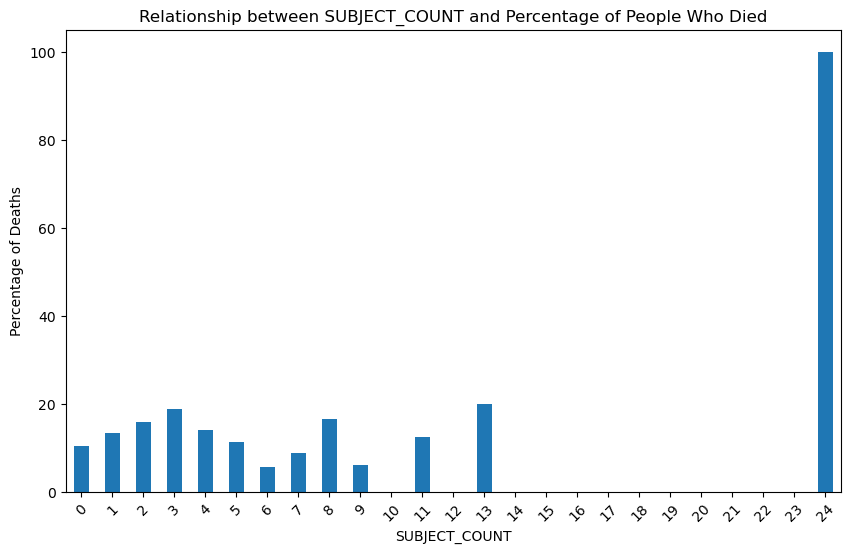

In [37]:
df = pd.concat([X_shape, y], axis=1)

subject_count_death_percentage = df.groupby('SUBJECT_COUNT')['HOSPITAL_EXPIRE_FLAG'].mean() * 100

plt.figure(figsize=(10, 6))

subject_count_death_percentage.plot(kind='bar')

plt.title('Relationship between SUBJECT_COUNT and Percentage of People Who Died')
plt.xlabel('SUBJECT_COUNT')
plt.ylabel('Percentage of Deaths')
plt.xticks(rotation=45)

plt.show()


Binning the vistis

In [38]:
X_shape = bin_visit(X_shape)
X_test = bin_visit(X_test)
test = bin_visit(test)

Visualizing the data after binning.

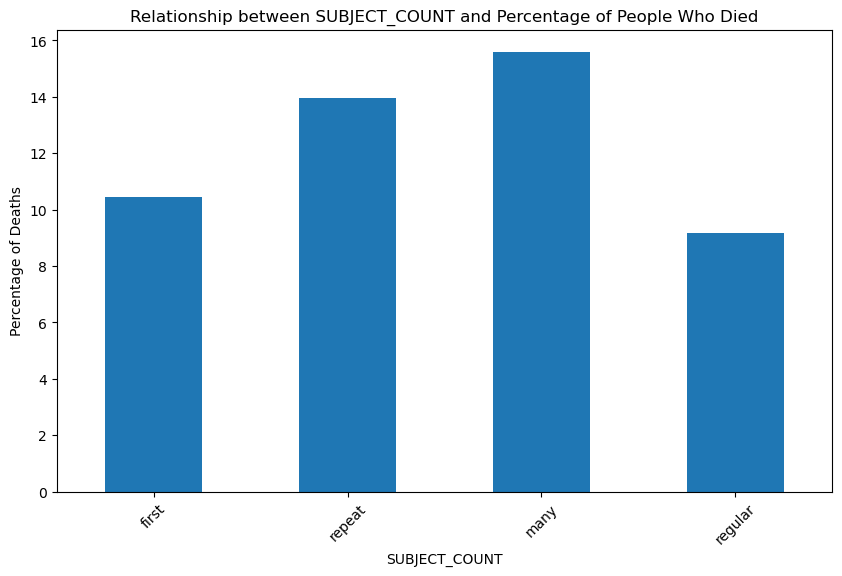

In [39]:
df = pd.concat([X_shape, y], axis=1)

subject_count_death_percentage = df.groupby('SUBJECT_COUNT')['HOSPITAL_EXPIRE_FLAG'].mean() * 100

plt.figure(figsize=(10, 6))

subject_count_death_percentage.plot(kind='bar')

plt.title('Relationship between SUBJECT_COUNT and Percentage of People Who Died')
plt.xlabel('SUBJECT_COUNT')
plt.ylabel('Percentage of Deaths')
plt.xticks(rotation=45)

plt.show()

Creating a dictionary in case I want to mean encode.

In [40]:
subject_count_death_percentage = subject_count_death_percentage.to_dict()

I do this throughout the notebook so I have two copies of datasets to work one in case I mess something up. That way I can reset easily.

In [41]:
X_shape1 = X_shape.copy()
X_test1 = X_test.copy()
test1 = test.copy()

## Insurance

I'm not doing anything with insurance here, I just wanted to see some information about Insurance. I didn't end up using Insurance in any of my models.

In [42]:
df[df['HOSPITAL_EXPIRE_FLAG'] == 1]['INSURANCE'].value_counts()/df['INSURANCE'].value_counts()

Medicare      0.134494
Private       0.085989
Medicaid      0.079358
Government    0.058920
Self Pay      0.144330
Name: INSURANCE, dtype: float64

In [43]:
insurance = df.groupby('INSURANCE')['HOSPITAL_EXPIRE_FLAG'].mean() * 100
insurance

INSURANCE
Government     5.891980
Medicaid       7.935758
Medicare      13.449394
Private        8.598879
Self Pay      14.432990
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

## Setting up the Data

Setting up the data:

In [44]:
test = test1.copy()
X_shape = X_shape1.copy()
X_test = X_test1.copy()
 
X_shape = X_shape.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})
X_test = X_test.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})
test = test.rename(columns={'subject_id': 'SUBJECT_ID', 'hadm_id': 'HADM_ID'})

Here, I am deciding which features to keep and how to encode each feature (i.e. target encoding vs dummies.) Generally for SVM, I was okay using more features as SVM handles noise better. However, for kNN, I had to be much more selective.

In [45]:
def data_prep(df):
    df = df.merge(pivoted_df[pulled_cols], on=['SUBJECT_ID', 'HADM_ID'], how='left')
    df['DIAGNOSIS'] = df['DIAGNOSIS'].map(merged_diag)
    df = find_age(df)
    #df = disease_dum(df, words)
    df['AGE_GROUP'] = df['AGE_GROUP'].map(age_to_death_rate)
    #df['AGE_GROUP'] = np.log(df['AGE_GROUP'])
    df['ADMISSION_TYPE'] = df['ADMISSION_TYPE'].apply(lambda x: label_mapping.get(x, x))
    df['GENDER'] = df['GENDER'].map({'M': 1, 'F': 0})
    #df = map_demographic(df)
    df['ETHNICITY'] = df['ETHNICITY'].apply(classify_ethnicity)
    #df = pd.get_dummies(df, prefix=['INSURANCE'], columns=['INSURANCE'], drop_first = False)
    df = pd.get_dummies(df, prefix=['ETHNICITY'], columns=['ETHNICITY'], drop_first = False)
    #df = pd.get_dummies(df, prefix=['FIRST_CAREUNIT'], columns=['FIRST_CAREUNIT'], drop_first = False)
    #df = pd.get_dummies(df, prefix=['SUBJECT_COUNT'], columns=['SUBJECT_COUNT'], drop_first = True)
    df['SUBJECT_COUNT'] = df['SUBJECT_COUNT'].map(subject_count_death_percentage)
    df = df.drop(['SUBJECT_ID','GENDER','HADM_ID','Diff','FIRST_CAREUNIT','INSURANCE'], axis=1)
    df.drop('ADMITTIME', axis = 1, inplace = True)
    return(df)


Preparing datasets. If there no train, test split is used, X_test can be ignored. However, I wanted my notebook to run seemlessly with "Run All" regardless of if there is a train test split used.

In [46]:
test = data_prep(test)
X_shape = data_prep(X_shape)
X_test = data_prep(X_test)

## Preprocessing

Imputed the mean for missing data. I tried median and mode but mean was the best.

In [47]:
cols = X_shape.columns.astype(str)
X_shape.columns = cols
X_test.columns = cols
test.columns = cols

In [48]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
imp_mean.fit(X_shape)

test = pd.DataFrame(imp_mean.transform(test))
X_test = pd.DataFrame(imp_mean.transform(X_test))
X_shape = pd.DataFrame(imp_mean.transform(X_shape))


To deal with imbalanced data in kNN< I tried SMOTE oversampling. However, it ended up overfitting my data substantially.

In [49]:
from imblearn.over_sampling import SMOTE
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_shape, y = smote.fit_resample(X_shape, y)
#oversampler = RandomOverSampler(sampling_strategy='auto')
#X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

Scaling the Dataset.

In [50]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_shape,y)

X_shape = scaler.transform(X_shape)
X_test = scaler.transform(X_test)
test = scaler.transform(test)

X_shape = pd.DataFrame(X_shape, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)
test = pd.DataFrame(test, columns = cols)

## Correlation Matrix

I want to see how the features I selected correlate with death as well as each other so I made a correlation matrix/heatmap.

In [51]:
joined = pd.concat([y,X_shape],axis=1)

def corr_matrix(df):
    corr_mat = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            corr_mat[i, j] = df.iloc[:, i].corr(df.iloc[:, j])
    corr_mat = pd.DataFrame(corr_mat, columns=df.columns, index=df.columns)
    return corr_mat
                                                   
corr_mat = corr_matrix(joined)

corr_with_HEF = corr_mat['HOSPITAL_EXPIRE_FLAG']
corr_with_HEF = corr_with_HEF.iloc[1:len(X_shape)]


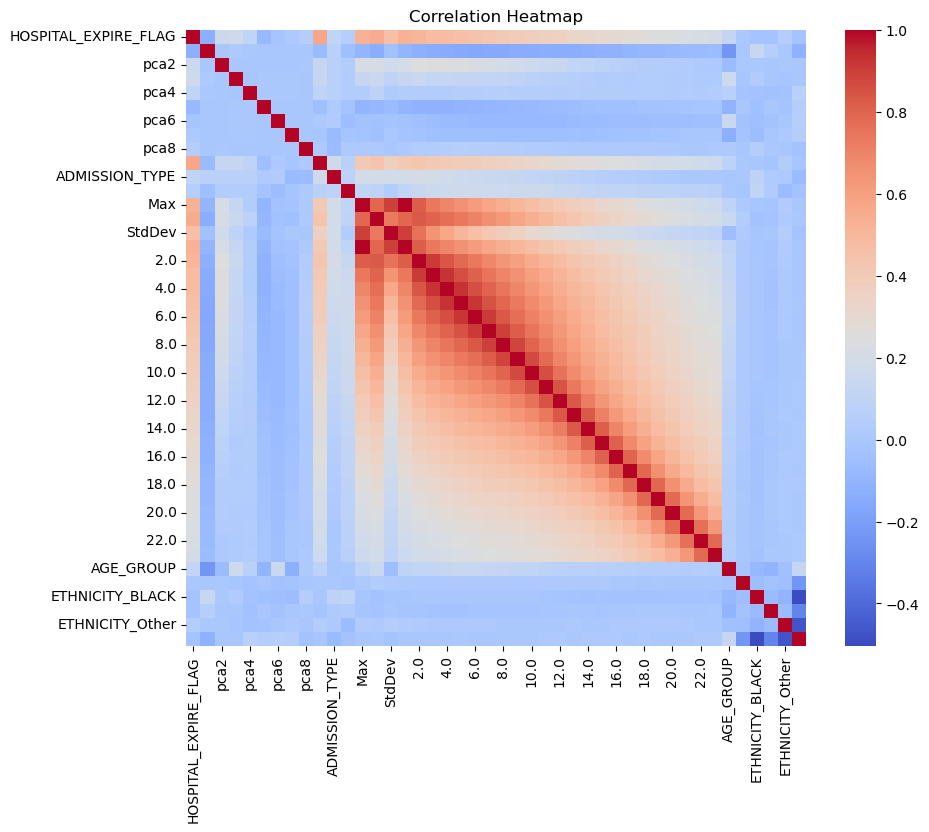

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Relationship specifcially between each feature and Hospital Expire Flag

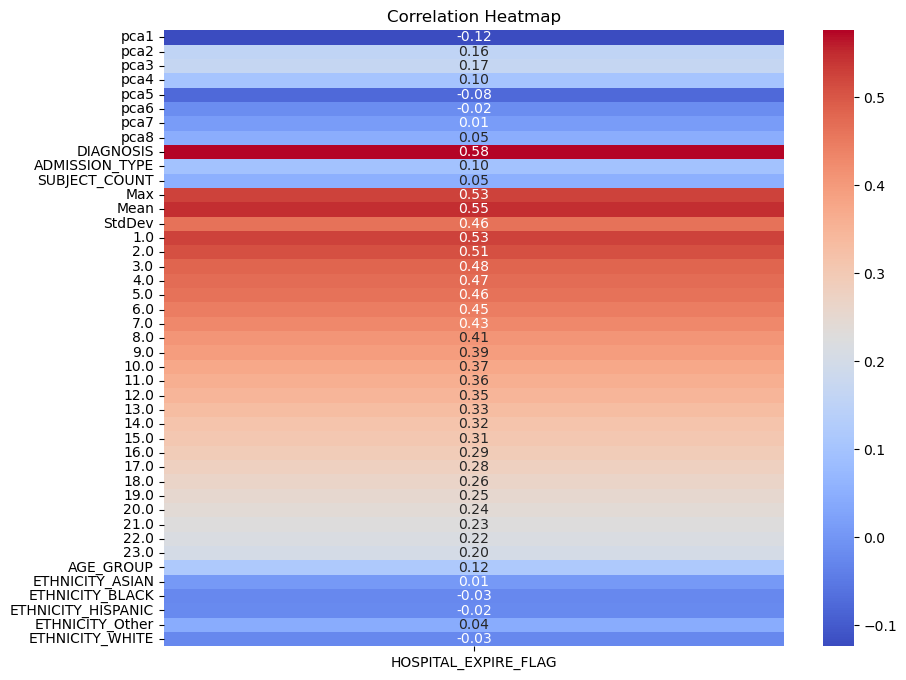

In [53]:
plot_corr = pd.DataFrame(corr_with_HEF)
plt.figure(figsize=(10, 8))
sns.heatmap(plot_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Something that I tried repeatedly was to artifically weight the dimensions for kNN as clealry some dimensions are much better predictors than others. I tried things like doubling or tripling important colunns. Below, I have to functions to scale the datasets by the correlation or variance. Whatever I did to try to weight the features always ended up drastically overfitting my training set.

In [54]:
def scale_by_corr(df, corr):
    for i in corr.index.tolist():
        df[i] = df[i] * abs(corr.loc[i])
    return(df)

def scale_by_var(df, corr):
    for i in corr.index.tolist():
        df[i] = df[i] * corr.loc[i] ** 2
    return(df)

#X_shape = scale_by_corr(X_shape, corr_with_HEF)
#X_test = scale_by_corr(X_test, corr_with_HEF)
#test = scale_by_corr(test, corr_with_HEF)

## Trying LASSO for feature selection

Just for fun, I tried running LASSO for feature selection. It didn't remove any features.

In [55]:
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [2,1,0.5,0.05,0.005]}
logistic_model = LogisticRegression(penalty='l1', solver='liblinear') 
grid_search = GridSearchCV(logistic_model, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_shape, y)


GridSearchCV(cv=10,
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [2, 1, 0.5, 0.05, 0.005]}, scoring='roc_auc')

In [56]:
lasso = grid_search.best_estimator_
lasso

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

In [57]:
coefficients = lasso.coef_.tolist()
dropped_features = X_shape.columns[coefficients == 0]
print("Dropped features:", dropped_features)

Dropped features: []


/var/folders/7g/swv044q57cq378zvy5rc1fj80000gn/T/ipykernel_54518/243866380.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dropped_features = X_shape.columns[coefficients == 0]


## Applying kNN or SVM

### For kNN
Trying different number of neighbors, how distances are weighted, and checking Manhattan distance vs. Euclidean distance. I used 20 fold cross validation. After many GridSearches, I found that weighting by distance and measuring by Manhattan Distance always produced the top results.

best parameters: {'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
best score:      0.95116 (+/-0.01029)


,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
1,50,1,distance,"{'n_neighbors': 50, 'p': 1, 'weights': 'distan...",0.940815,0.944257,0.953504,0.957732,0.953472,0.955956,...,0.961008,0.939535,0.957251,0.941586,0.920583,0.949285,0.967467,0.951163,0.010286,1
2,100,1,distance,"{'n_neighbors': 100, 'p': 1, 'weights': 'dista...",0.935924,0.947891,0.949870,0.953728,0.949623,0.957219,...,0.961700,0.934593,0.956633,0.937778,0.926461,0.951539,0.966047,0.950238,0.009968,2
3,110,1,distance,"{'n_neighbors': 110, 'p': 1, 'weights': 'dista...",0.934864,0.948979,0.949591,0.953024,0.948910,0.956490,...,0.961137,0.931762,0.957270,0.936875,0.929439,0.950935,0.965323,0.949942,0.009906,3
0,40,1,distance,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",0.935792,0.939700,0.948997,0.954697,0.953628,0.954600,...,0.960538,0.939562,0.956873,0.943006,0.918393,0.950281,0.967236,0.949418,0.010735,4
4,150,1,distance,"{'n_neighbors': 150, 'p': 1, 'weights': 'dista...",0.933918,0.946803,0.947841,0.951443,0.947493,0.953623,...,0.962198,0.930942,0.954780,0.934505,0.928752,0.950281,0.963705,0.948274,0.009820,5


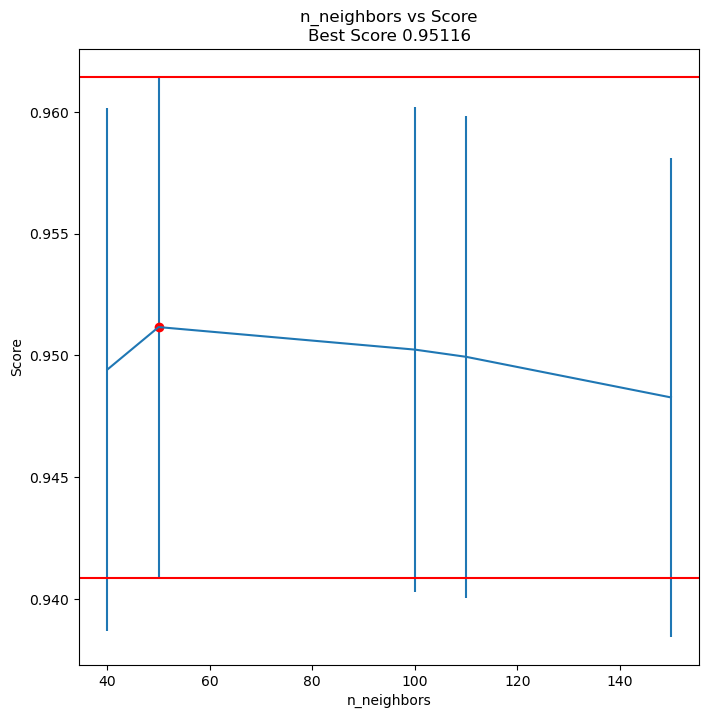

In [58]:

#grid_knn_acc = KNeighborsClassifier(n_neighbors=165, weights = 'distance', p = 1, algorithm='brute')
MyKNN = KNeighborsClassifier(algorithm='auto')
grid_values = {'n_neighbors':[40,50,100,110,150], 'weights':['distance'], 'p':[1]}
grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc' , cv=20)
grid_knn_acc.fit(X_shape, y)
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)


### For SVM

For SVM, I ran gridsearch for hyperparamater tuning. I maxed out iterations at 5000 for expediance's sake. Hyperparamter tuning for SVM was less clear than with kNN but a rbf kernel with the default gamma usually returned the best predicitons. GridSearch consistently gave me too large of a gamma which vastly overfit my model.

I did use a weighted class balance as around 10% of the people in the hospital died.

In [59]:
'''
from sklearn.svm import SVC
my_SVM_model = SVC(class_weight='balanced', max_iter=5000)
grid_values = {'C':[1,0.1,0.01],'gamma': [0.1,0.5,1,'scale'], 'kernel':['linear','rbf']}
grid_svc_acc = GridSearchCV(my_SVM_model, param_grid = grid_values, scoring = 'accuracy', cv=5)
grid_svc_acc.fit(X_shape, y)
GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)
'''

'\nfrom sklearn.svm import SVC\nmy_SVM_model = SVC(class_weight=\'balanced\', max_iter=5000)\ngrid_values = {\'C\':[1,0.1,0.01],\'gamma\': [0.1,0.5,1,\'scale\'], \'kernel\':[\'linear\',\'rbf\']}\ngrid_svc_acc = GridSearchCV(my_SVM_model, param_grid = grid_values, scoring = \'accuracy\', cv=5)\ngrid_svc_acc.fit(X_shape, y)\nGridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)\n'

Running the actual SVM model.

In [60]:

from sklearn.svm import SVC
new_SVM_model = SVC(C=0.1, gamma = 'scale',kernel= 'rbf', class_weight='balanced', probability= True)
new_SVM_model.fit(X_shape,y)


SVC(C=0.1, class_weight='balanced', probability=True)

Testing Out of Sample Data (Relevant for TrainTestSplit)

In [61]:
#y_pred_prob = grid_knn_acc.predict_proba(X_test)[:, 1]
y_pred_prob = new_SVM_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
auc

0.9622991555279992

## Predictions for Testing Data

In [62]:
test_probs = grid_knn_acc.predict_proba(test)
#test_probs = new_SVM_model.predict_proba(test)
test_probs

array([[1.        , 0.        ],
       [0.77642625, 0.22357375],
       [1.        , 0.        ],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

Reweighting SVM predictions:

In [63]:
'''
class_weights = new_SVM_model.class_weight_
inverted_weights = 1.0 / class_weights
scaled_test_probs = test_probs * inverted_weights
scaled_test_probs

#Some of the probabilites fell outside of [0,1]
scaled_test_probs = np.clip(scaled_test_probs, 0, 1)
scaled_test_probs
'''

'\nclass_weights = new_SVM_model.class_weight_\ninverted_weights = 1.0 / class_weights\nscaled_test_probs = test_probs * inverted_weights\nscaled_test_probs\n\n#Some of the probabilites fell outside of [0,1]\nscaled_test_probs = np.clip(scaled_test_probs, 0, 1)\nscaled_test_probs\n'

In [65]:
predictions = testset[['icustay_id']]
predictions['HOSPITAL_EXPIRE_FLAG'] = list(test_probs[:,1])
#predictions['HOSPITAL_EXPIRE_FLAG'] = list(scaled_test_probs[:,1])

predictions.to_csv('kagglechen.csv', index = False)
predictions

/var/folders/7g/swv044q57cq378zvy5rc1fj80000gn/T/ipykernel_54518/1047474413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['HOSPITAL_EXPIRE_FLAG'] = list(test_probs[:,1])


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.000000
1,251754,0.223574
2,242171,0.000000
3,263035,0.039469
4,279388,0.079875
...,...,...
5216,278087,0.059869
5217,266914,0.316867
5218,213413,0.000000
5219,286384,0.000000


## Conclusion

PCA was helpful in kNN for reducing dimensionality of Vitals. I wonder if I could have used it more specifcially to target just blood pressure, or just heart rate. PCA could also be helpful in reducing dimensionality of the 23 additional ICD9 columns as there is crealy high correlation among them.

Originally, I was using CDC data for a lot of the demographic data. I ended up switching to mean encoding as it was more beneficial. However, the issue with mean encoding is overfitting to the training data. Therefore, I used dummy varibales where I could. However, I do like my idea of using outside research like the CDC data but I would need more specific data regarding Emergency Room mortality.

I imputed the mean for all the columns, which ended up working the best. However, This is probabily not the best method for all the columns. Given more time, I would've used different methods to impute different values depending on the skewness/type of data.

Something that I thought about a lot was how to create interation terms between columns. I ended up not doing it but clearly if, say, you're two highest ICD9 diagnoses are both related to cardiac isseus, that is very different than if they one was a cardiac issue and the other was a gastrointestinal issue (I would presume with my limited medical knowlege).